In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')


### Reading the dataset and getting the info

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
# Show Sample of Data
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0
541,76,M,NAP,104,113,0,LVH,120,N,3.5,Down,1
390,51,M,ASY,140,0,0,Normal,60,N,0.0,Flat,1
611,62,M,TA,135,139,0,ST,137,N,0.2,Up,0


In [6]:
# Show Shape of Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Row : 918
Number of Columns : 12


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
# Check NaN Value
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
# Describe Numiric Data
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


All this an errors in data collection¶
- the min value in 2 columns = 0 (RestingBP, Cholesterol) is not realistic
- An Oldpeak value of -2.6 mm is not realistic because ST depression (Oldpeak) cannot be negative

In [11]:
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})

,Count,Null,Null %,Cardinality
Age,918,0,0.0,50
Sex,918,0,0.0,2
ChestPainType,918,0,0.0,4
RestingBP,918,0,0.0,67
Cholesterol,918,0,0.0,222
FastingBS,918,0,0.0,2
RestingECG,918,0,0.0,3
MaxHR,918,0,0.0,119
ExerciseAngina,918,0,0.0,2
Oldpeak,918,0,0.0,53


In [12]:
# Check Dublication
df.duplicated().sum()

0

### Handling missing data (Nulls)

##### Handle not realistic value (RestingBP, Cholesterol,Oldpeak)

The negative reviews are real but were entered incorrectly because Oldpeak should be positive

In [16]:
df[df['Oldpeak']<0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
321,63,M,ASY,100,0,1,Normal,109,N,-0.9,Flat,1
324,46,M,ASY,100,0,1,ST,133,N,-2.6,Flat,1
325,42,M,ASY,105,0,1,Normal,128,Y,-1.5,Down,1
326,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
331,56,M,ASY,115,0,1,ST,82,N,-1.0,Up,1
332,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
334,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
335,62,M,TA,120,0,1,LVH,134,N,-0.8,Flat,1
352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
407,62,M,ASY,115,0,1,Normal,72,Y,-0.5,Flat,1


In [17]:
# Change negative values to positive values
df['Oldpeak'] = df['Oldpeak'].abs()

Convert those 0's values in these 2 columns (RestingBP, Cholesterol) to determine how many missing valuesin each feature in our data

In [19]:
df[['RestingBP','Cholesterol']] = df[['RestingBP','Cholesterol']].replace(0,np.nan)

In [20]:
# Show Number of Missing Values (NaN)
df[['RestingBP','Cholesterol']].isna().sum()

RestingBP        1
Cholesterol    172
dtype: int64

In [21]:
# Show Status of HeartDisease which NaN in RestingBP
df[df['RestingBP'].isna()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,NaN,NaN,0,Normal,155,N,1.5,Flat,1


In [22]:
# Fill Missing Value with median of people has Heart Disease
df['RestingBP'] = df['RestingBP'].fillna(df.groupby('HeartDisease')['RestingBP'].median()[1])

In [23]:
temp = df.groupby('HeartDisease')['Cholesterol'].median()
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 0), 'Cholesterol'] = temp[0]
df.loc[(df['Cholesterol'].isna()) & (df['HeartDisease'] == 1), 'Cholesterol'] = temp[1]

In [24]:
# After Fill Missing Values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Detection Outliers

In [26]:
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Age: 0 outliers detected
RestingBP: 27 outliers detected
Cholesterol: 41 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 15 outliers detected


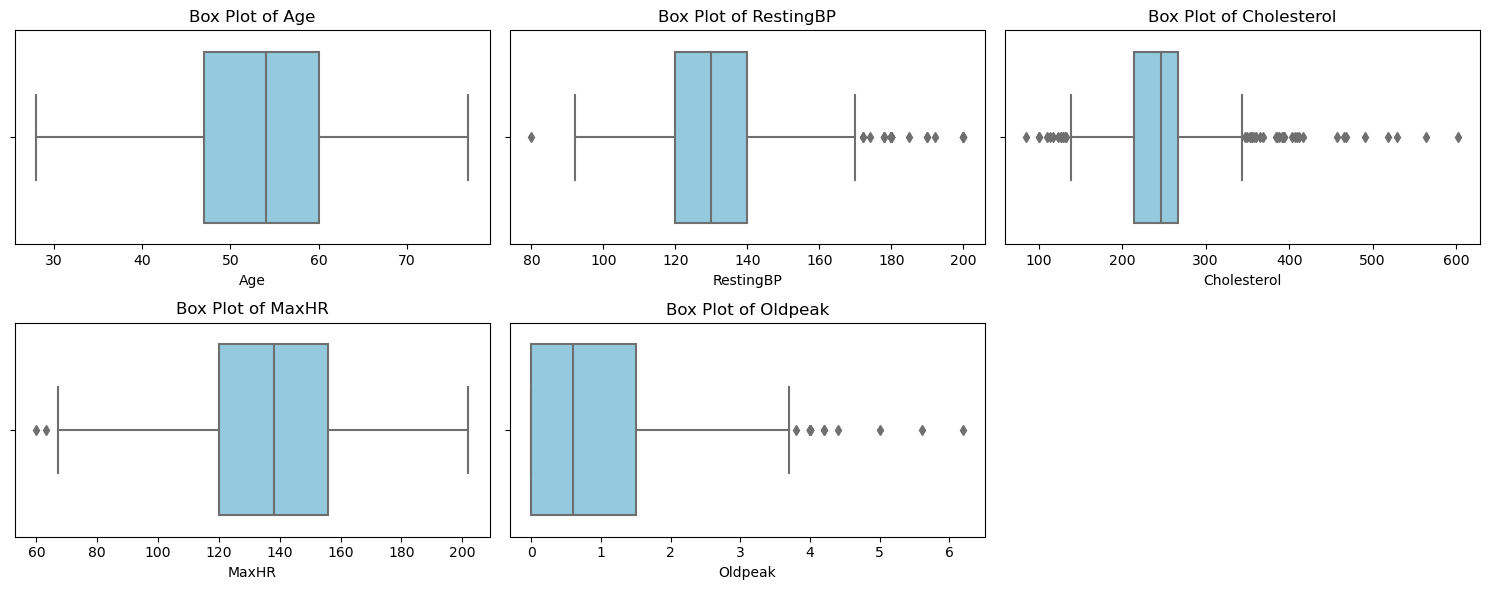

In [27]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [28]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

In [29]:
# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}\nNumber of Columns : {df_cleaned.shape[1]}")

Number of Row : 824
Number of Columns : 12


##### Cleaned Data BoxPlot To Show Outliers

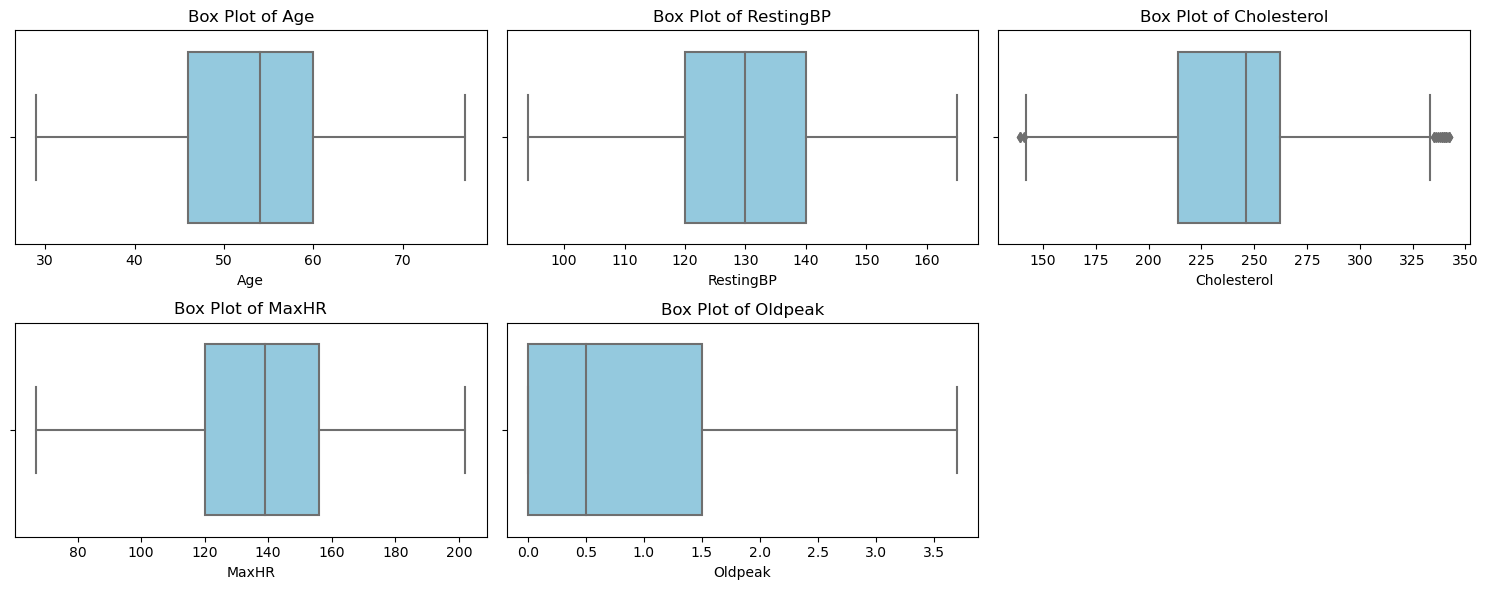

In [31]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x = df_cleaned[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()


In [32]:
df_cleaned.reset_index(inplace = True , drop = True)
df_cleaned.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
113,48,F,ASY,108.0,163.0,0,Normal,175,N,2.0,Up,0
150,48,M,ATA,140.0,238.0,0,Normal,118,N,0.0,Up,0
660,49,M,NAP,120.0,188.0,0,Normal,139,N,2.0,Flat,1
586,48,M,ASY,122.0,222.0,0,LVH,186,N,0.0,Up,0
623,58,M,ASY,146.0,218.0,0,Normal,105,N,2.0,Flat,1


In [33]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             824 non-null    int64  
 1   Sex             824 non-null    object 
 2   ChestPainType   824 non-null    object 
 3   RestingBP       824 non-null    float64
 4   Cholesterol     824 non-null    float64
 5   FastingBS       824 non-null    int64  
 6   RestingECG      824 non-null    object 
 7   MaxHR           824 non-null    int64  
 8   ExerciseAngina  824 non-null    object 
 9   Oldpeak         824 non-null    float64
 10  ST_Slope        824 non-null    object 
 11  HeartDisease    824 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 77.4+ KB


### EDA of Data and Getting Insights

##### Age distribution in the data

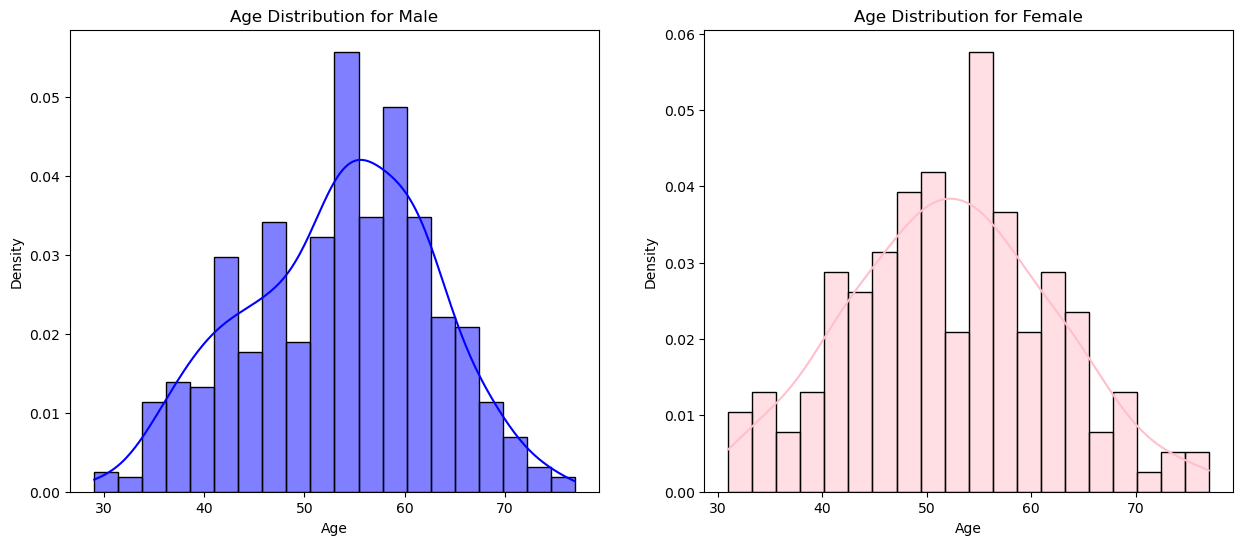

In [36]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)

sns.histplot(df_cleaned[df['Sex'] == 'M']['Age'], color='blue', kde=True, bins=20, stat='density')
plt.title('Age Distribution for Male')

plt.subplot(1,2,2)

sns.histplot(df_cleaned[df['Sex'] == 'F']['Age'], color='pink', kde=True, bins=20, stat='density')
plt.title('Age Distribution for Female')

plt.show()

- Most Ranges of Age between 50 to 60

In [38]:
fig = px.pie(values = df_cleaned['Sex'].value_counts(),
             names = ['Male','Female'],
             template = 'plotly_dark',
             title = 'The Percentage of Type of Gender in the Data'
             ).update_traces(textinfo='label+percent')
pio.renderers.default = 'iframe'
fig.show()

- Males are the dominant Category in the data

#####  Chest Pain Type For each gender of Sex

In [41]:
fig = px.bar(df_cleaned[df_cleaned['Sex'] == 'M']['ChestPainType'].value_counts(),
             color = df_cleaned[df_cleaned['Sex'] == 'M']['ChestPainType'].value_counts().index,
             template = 'plotly_dark',
             title = 'Most Chest Pain Type For Male',
             labels = {'value':'Count'},
             text_auto = True
             )
fig.show()

In [42]:
fig = px.bar(df_cleaned[df_cleaned['Sex'] == 'F']['ChestPainType'].value_counts(),
             color = df_cleaned[df_cleaned['Sex'] == 'F']['ChestPainType'].value_counts().index,
             template = 'plotly_dark',
             title = 'Most Chest Pain Type For Female',
             labels = {'value':'Count'},
             text_auto = True
             )
fig.show()

In [43]:
fig = px.bar(df_cleaned['ChestPainType'].value_counts(),
             color = df_cleaned['ChestPainType'].value_counts().index,
             template = 'plotly_dark',
             title = 'Most Chest Pain Type In General',
             labels = {'value':'Count'},
             text_auto = True
             )
fig.show()

Most Chest Pain Type
- Male and Female Most Common occur -> ASY: Asymptomatic
- Male and Female Least Common occur -> TA: Typical Angina

##### Distribution of Resting Blood Pressure

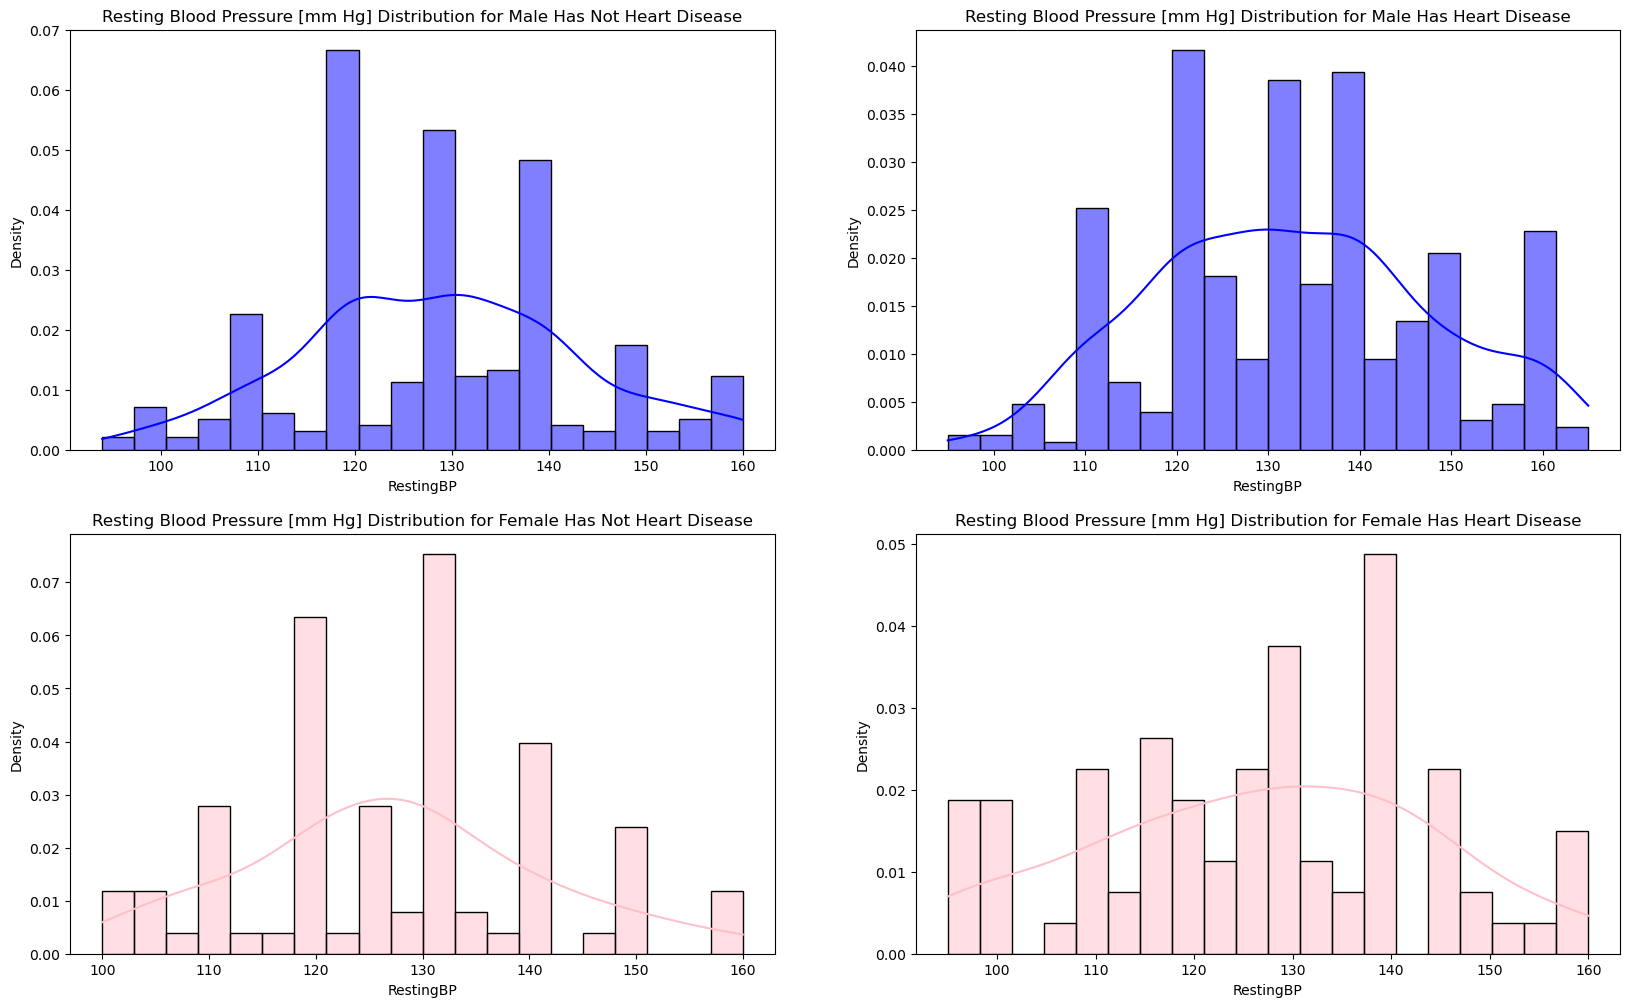

In [46]:
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['RestingBP'], color='blue', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Male Has Not Heart Disease')

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['RestingBP'], color='blue', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Male Has Heart Disease')

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['RestingBP'], color='pink', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Female Has Not Heart Disease')

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['RestingBP'], color='pink', kde=True, bins=20, stat='density')
plt.title('Resting Blood Pressure [mm Hg] Distribution for Female Has Heart Disease')

plt.show()

##### Distribution of Cholesterol

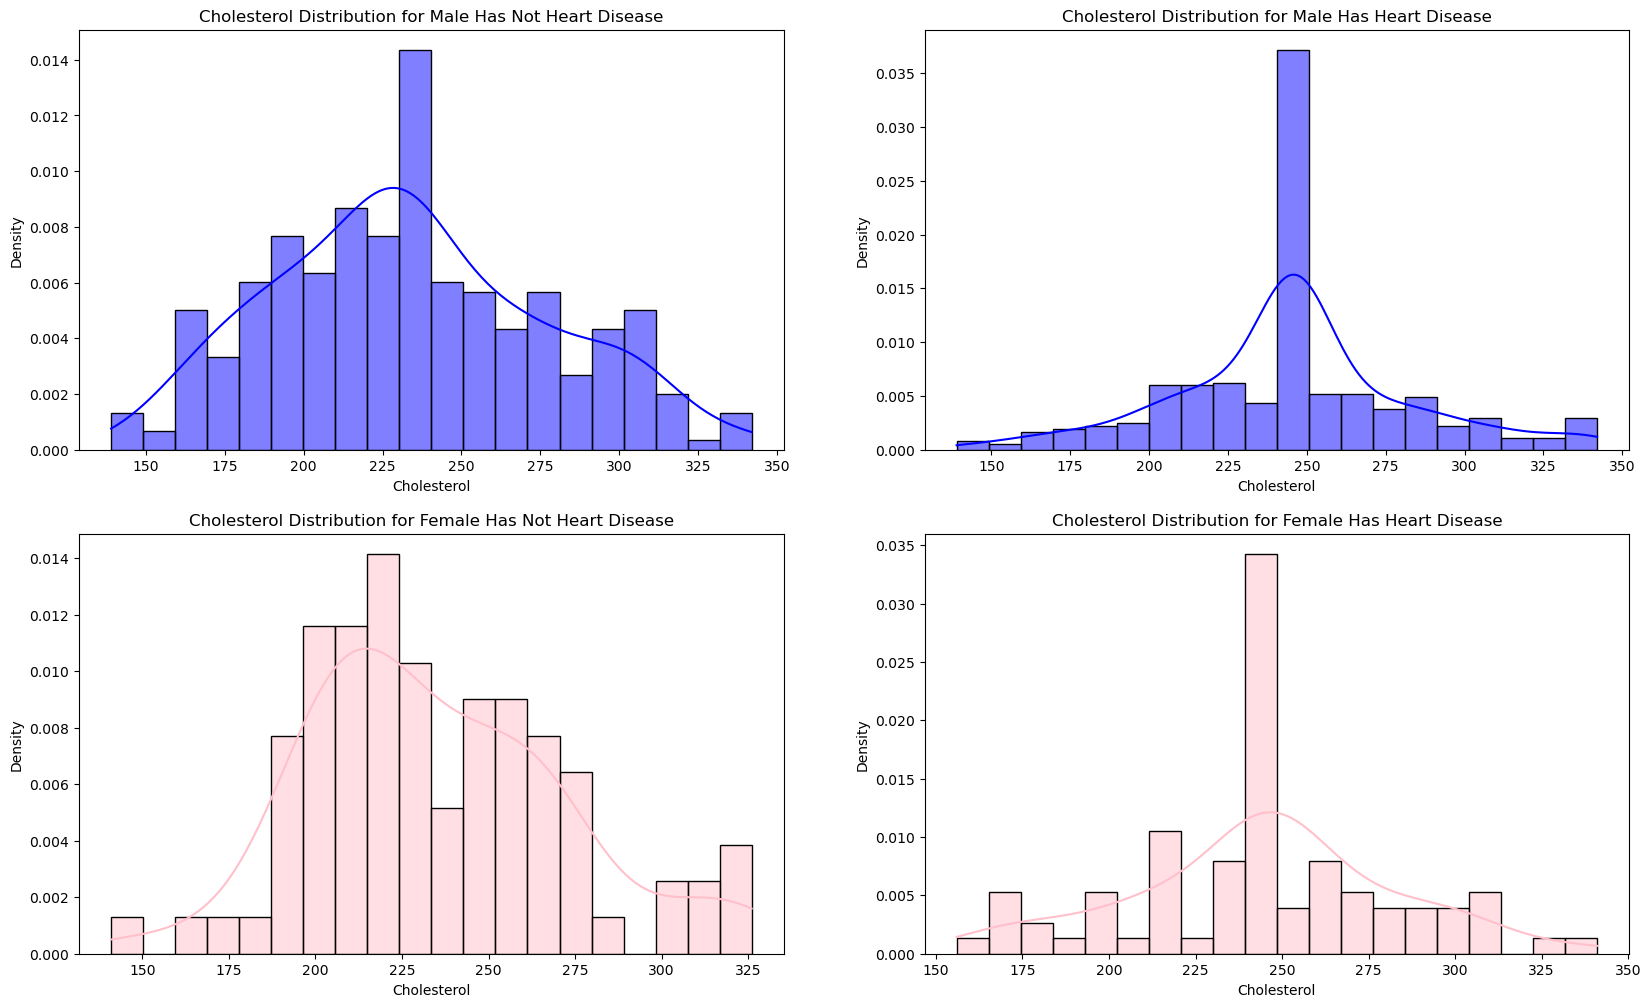

In [48]:
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['Cholesterol'], color='blue', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Male Has Not Heart Disease')

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['Cholesterol'], color='blue', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Male Has Heart Disease')

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['Cholesterol'], color='pink', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Female Has Not Heart Disease')

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['Cholesterol'], color='pink', kde=True, bins=20, stat='density')
plt.title('Cholesterol Distribution for Female Has Heart Disease')

plt.show()

##### Percentage of fasting For people has heart disease or not

In [50]:
fig = px.pie(values = df_cleaned[(df_cleaned['HeartDisease'] == 0)]['FastingBS'].value_counts(),
             names = ['otherwise','FastingBS > 120 mg'],
             template = 'plotly_dark',
             title = 'The Percentage of FastingBS in For People has Not Heart Disease'
             ).update_traces(textinfo='label+percent')

fig.show()

In [51]:
fig = px.pie(values = df_cleaned[(df_cleaned['HeartDisease'] == 1)]['FastingBS'].value_counts(),
             names = ['otherwise','FastingBS > 120 mg'],
             template = 'plotly_dark',
             title = 'The Percentage of FastingBS in For People has Heart Disease'
             ).update_traces(textinfo='label+percent')

fig.show()

- A higher rate of fasting affects the appearance of heart disease in people


##### Resting Electrocardiogram Results (RestingECG) for people has Heart Disease or not

In [54]:
fig = px.pie(values = df_cleaned[(df_cleaned['HeartDisease'] == 0)]['RestingECG'].value_counts(),
             names = ['Normal','LVH','ST'],
             template = 'plotly_dark',
             title = 'The Percentage of Resting Electrocardiogram Results (RestingECG) in For People has Not Heart Disease'
             ).update_traces(textinfo='label+percent')

fig.show()

In [55]:
fig = px.pie(values = df_cleaned[(df_cleaned['HeartDisease'] == 1)]['RestingECG'].value_counts(),
             names = ['Normal','ST','LVH'],
             template = 'plotly_dark',
             title = 'The Percentage of Resting Electrocardiogram Results (RestingECG) in For People has Heart Disease'
             ).update_traces(textinfo='label+percent')

fig.show()

##### Distribution of Maximum Heart Rate Achieved (MaxHR)

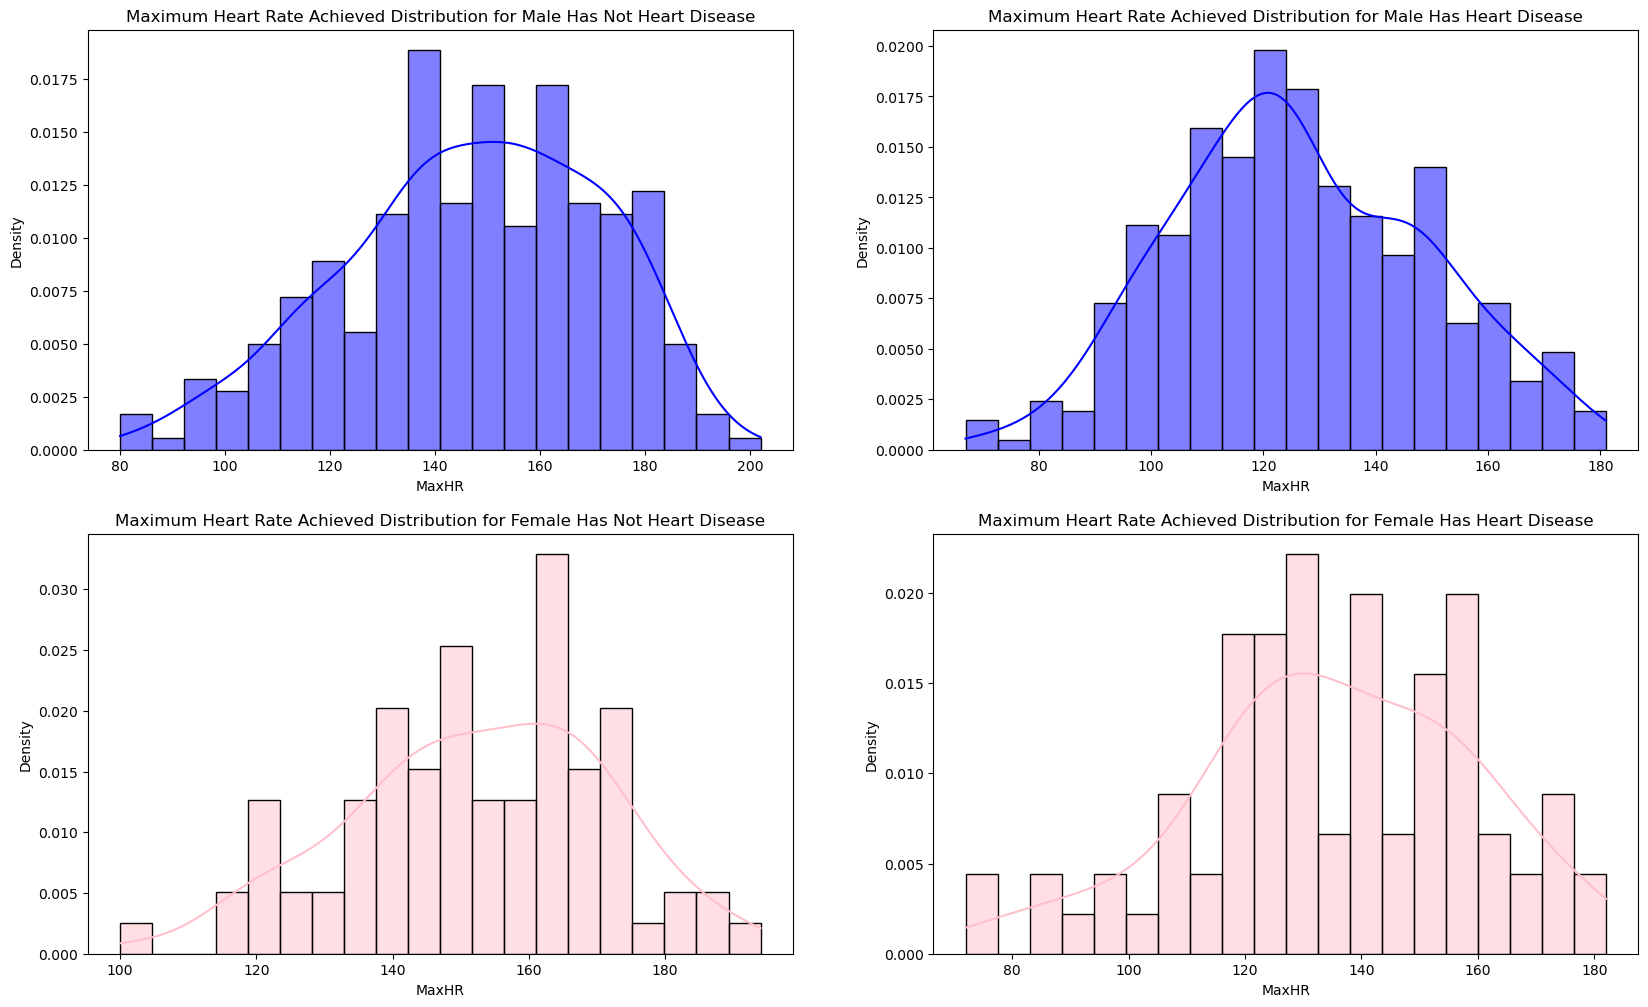

In [57]:
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['MaxHR'], color='blue', kde=True, bins=20, stat='density')
plt.title('Maximum Heart Rate Achieved Distribution for Male Has Not Heart Disease')

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['MaxHR'], color='blue', kde=True, bins=20, stat='density')
plt.title('Maximum Heart Rate Achieved Distribution for Male Has Heart Disease')

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['MaxHR'], color='pink', kde=True, bins=20, stat='density')
plt.title('Maximum Heart Rate Achieved Distribution for Female Has Not Heart Disease')

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['MaxHR'], color='pink', kde=True, bins=20, stat='density')
plt.title('Maximum Heart Rate Achieved Distribution for Female Has Heart Disease')

plt.show()

##### Oldpeak for people has Heart Disease or not

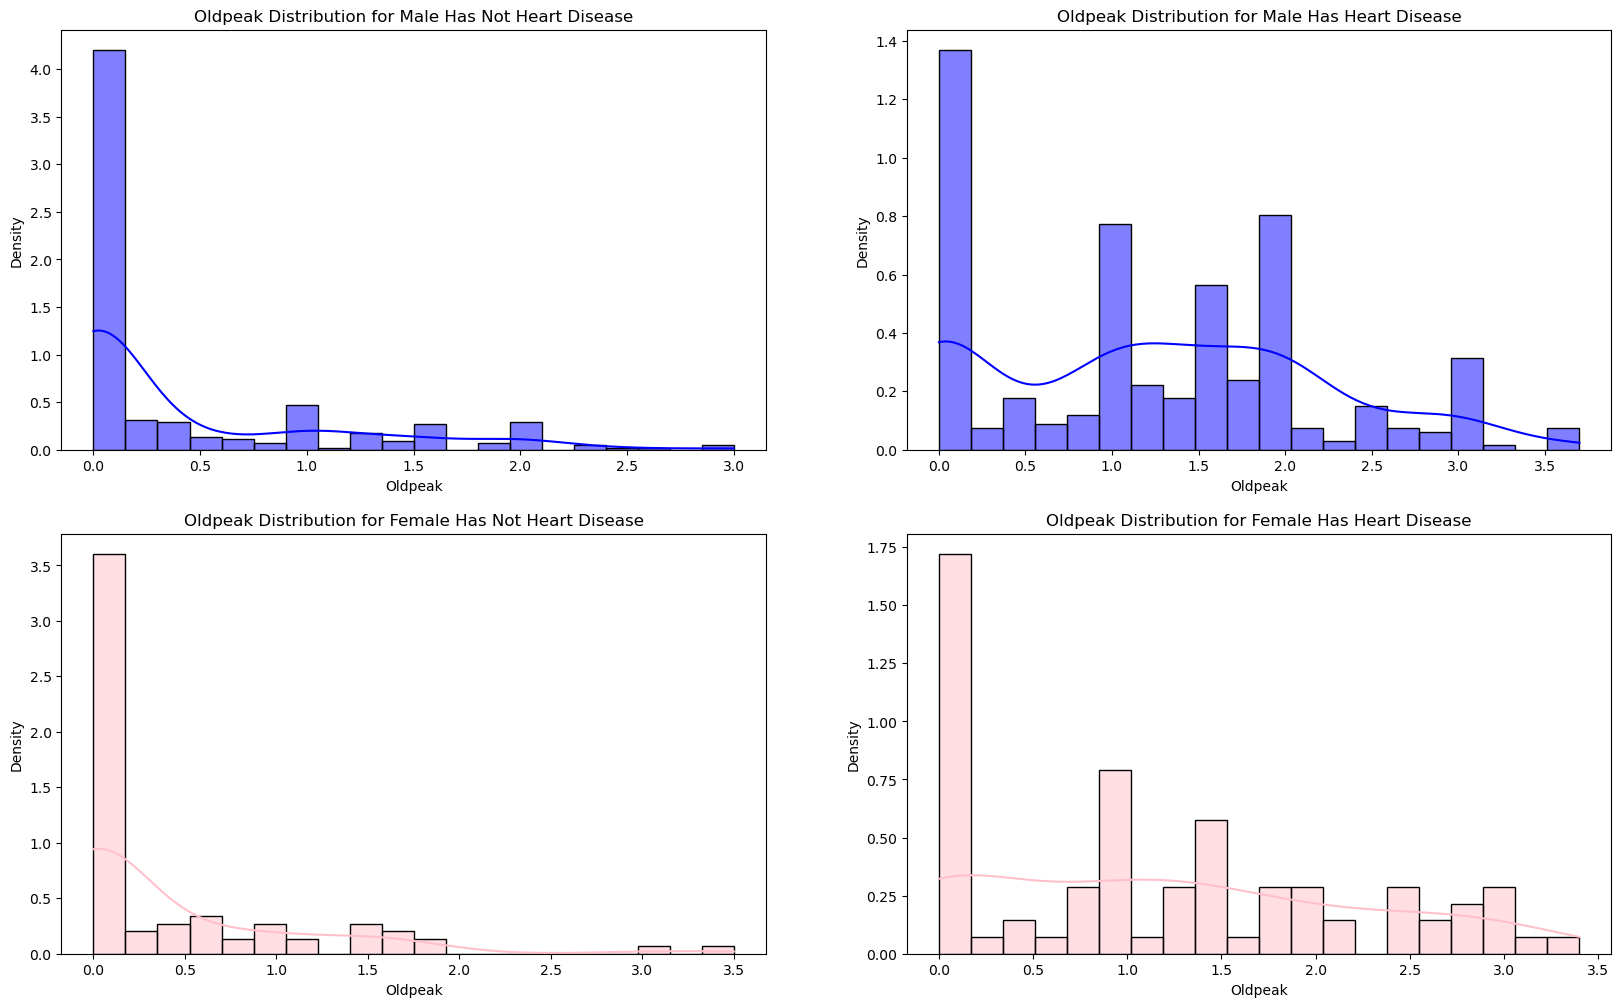

In [59]:
plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 0)]['Oldpeak'], color='blue', kde=True, bins=20, stat='density')
plt.title('Oldpeak Distribution for Male Has Not Heart Disease')

plt.subplot(2,2,2)

sns.histplot(df_cleaned[(df['Sex'] == 'M') & (df_cleaned['HeartDisease'] == 1)]['Oldpeak'], color='blue', kde=True, bins=20, stat='density')
plt.title('Oldpeak Distribution for Male Has Heart Disease')

plt.subplot(2,2,3)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 0)]['Oldpeak'], color='pink', kde=True, bins=20, stat='density')
plt.title('Oldpeak Distribution for Female Has Not Heart Disease')

plt.subplot(2,2,4)

sns.histplot(df_cleaned[(df['Sex'] == 'F') & (df_cleaned['HeartDisease'] == 1)]['Oldpeak'], color='pink', kde=True, bins=20, stat='density')
plt.title('Oldpeak Distribution for Female Has Heart Disease')

plt.show()

- Higher Oldpeak values are strongly correlated with the presence of Heart Disease, indicating more severe heart ischemia or coronary artery disease.

##### Total Insights
- Most Ranges of Age between 50 to 60
- Males are the dominant Category in the data
- Male and Female Most Common occur -> ASY: Asymptomatic
- Male and Female Least Common occur -> TA: Typical Angina
- A higher rate of fasting affects the appearance of heart disease in people
- The Presence of Exercise Results in a higher probability of Angina Pectoris occurring
- Higher Oldpeak values are strongly correlated with the presence of Heart Disease, indicating more severe heart ischemia or coronary artery disease.
- Flat (flat) is more strongly correlated with heart disease, while Upsloping (Up) and Down (DownSloping) are typically associated with normal heart function or less severe heart issues.

### Data Preprocessing

##### Handling Object DataType

Encode Object DataType

In [64]:
column_to_encode = df.select_dtypes(object).columns.tolist()
le = LabelEncoder()
for column in column_to_encode:
    df_cleaned[column] = le.fit_transform(df_cleaned[column])

In [65]:
# Show Data After some of Encode
df_cleaned.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140.0,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160.0,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130.0,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138.0,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150.0,195.0,0,1,122,0,0.0,2,0


In [66]:
# Final Info after Encode
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             824 non-null    int64  
 1   Sex             824 non-null    int64  
 2   ChestPainType   824 non-null    int64  
 3   RestingBP       824 non-null    float64
 4   Cholesterol     824 non-null    float64
 5   FastingBS       824 non-null    int64  
 6   RestingECG      824 non-null    int64  
 7   MaxHR           824 non-null    int64  
 8   ExerciseAngina  824 non-null    int64  
 9   Oldpeak         824 non-null    float64
 10  ST_Slope        824 non-null    int64  
 11  HeartDisease    824 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 77.4 KB


##### Assign feature and target variables

In [68]:
X = df_cleaned.drop('HeartDisease' , axis = 1)
y = df_cleaned['HeartDisease']

##### Splitting Data

In [70]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.25 , random_state = 44 , shuffle = True)

In [71]:
print(f'Shape of X_Train {X_train.shape}')
print(f'Shape of X_Test {X_test.shape}')
print(f'Shape of Y_Train {y_train.shape}')
print(f'Shape of Y_Test {y_test.shape}')

Shape of X_Train (618, 11)
Shape of X_Test (206, 11)
Shape of Y_Train (618,)
Shape of Y_Test (206,)


### Modeling

##### Use Different Models Algorithm

In [74]:
def Kfold(model,model_name):
    model = cross_val_score(model , X , y , cv = 10)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model,model_name):
    model.fit(X_train,y_train)
    model_train_score = model.score(X_train,y_train)
    model_test_score = model.score(X_test,y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def class_report(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

#### Random Forest

In [76]:
rf = RandomForestClassifier(n_estimators = 100 , max_depth = 50)
Kfold(rf, "Random Forest")
train(rf, "Random Forest")

Random Forest score on cross validation: 86.62650602409639%
Random Forest model score on Training data: 100.0%
Random Forest model score on Testing data: 89.80582524271846%


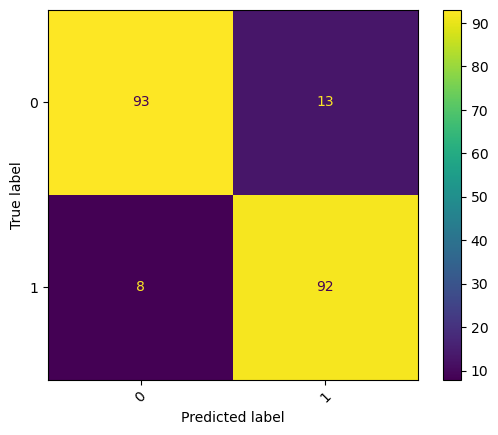

In [77]:
ConfusionMatrixDisplay.from_estimator(rf,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [78]:
class_report(rf)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       106
           1       0.88      0.92      0.90       100

    accuracy                           0.90       206
   macro avg       0.90      0.90      0.90       206
weighted avg       0.90      0.90      0.90       206



#### Xgboost

In [80]:
xgboost = model = XGBClassifier(objective = "binary:logistic" , subsample = 0.7 , min_child_weight = 3,
                                max_depth = 3 , learning_rate = 0.1 , gamma = 0 , colsample_bytree = 0.5,)
# Define your function properly
def Kfold(model, model_name):
    scores = cross_val_score(model, X, y, cv=10)
    model_score = np.mean(scores)
    print(f"{model_name} score on cross-validation: {model_score * 100:.2f}%")

# Call function with a model instance
Kfold(xgboost, "XGBoost")
train(xgboost, "Xgboost")

XGBoost score on cross-validation: 86.74%
Xgboost model score on Training data: 94.01294498381877%
Xgboost model score on Testing data: 89.80582524271846%


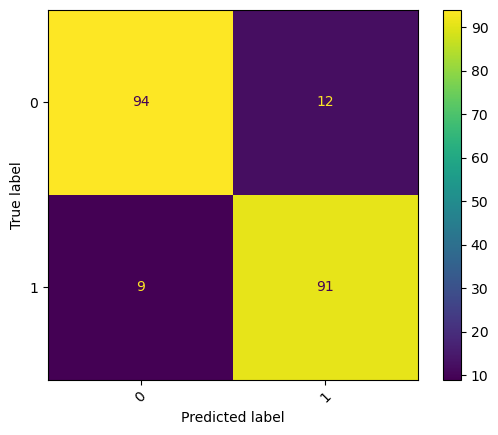

In [141]:
ConfusionMatrixDisplay.from_estimator(xgboost,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [143]:
class_report(xgboost)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       106
           1       0.88      0.91      0.90       100

    accuracy                           0.90       206
   macro avg       0.90      0.90      0.90       206
weighted avg       0.90      0.90      0.90       206



#### Save RandomForestClassifier Model

In [146]:
joblib.dump(rf,'RandomForestClassifier_model.sav')

['RandomForestClassifier_model.sav']